In [1]:
import pandas as pd
import numpy as np
import requests
from math import floor
import matplotlib.pyplot as plt
import yfinance as yf

ticker_1 = yf.Ticker("NFLX")
pSeries = ticker_1.history(start= "2020-01-01", end = "2024-04-30")["Close"]
df = pSeries.to_frame()
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')
close_df = df

/home/koharr/miniconda3/envs/machine-learning/lib/python3.11/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [2]:
def get_stochastic_oscillator(df , fast_period=14 , slow_period=3 ):
    close_df[ 'best_high' ] = close_df['Close'].rolling( fast_period ).apply(lambda s : s.max() )
    close_df[ 'best_low' ]  = close_df['Close'].rolling( fast_period ).apply(lambda s : s.min() )
    close_df[ 'fast_k' ]    = 100*((close_df['Close']-close_df['best_low'])/(close_df['best_high']-close_df['best_low']))
    close_df['fast_d'] = close_df['fast_k'].rolling( slow_period ).mean().round(2)
    close_df['slow_k'] = close_df['fast_d']
    close_df['slow_d'] = close_df['slow_k'].rolling( slow_period ).mean().round(2)
    return df
stoch_df = get_stochastic_oscillator(close_df)
stoch_df['Date'] = stoch_df.index

<Figure size 1600x800 with 0 Axes>

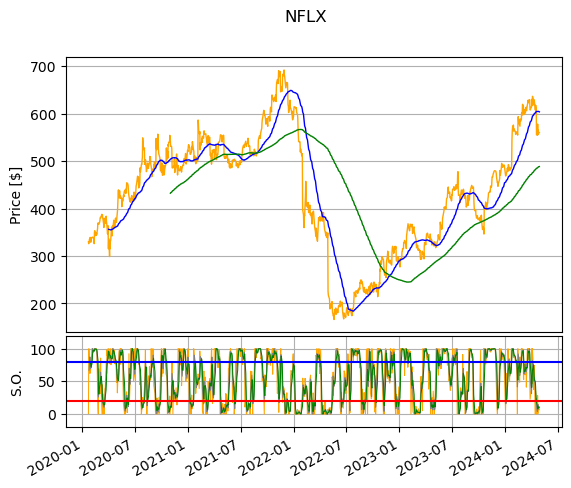

In [3]:
def chart_stochastic_oscillator_and_price(ticker, df):
    plt.figure(figsize=(16,8))
    plt.style.use('default')
    
    fig, ax = plt.subplots(2,gridspec_kw={'height_ratios':[3,1]}) 
    fig.suptitle(ticker)
    plt.subplots_adjust(hspace=0.02)
    
    # Price Chart
    df['ma50'] = df['Close'].rolling(50).mean()
    df['ma200'] = df['Close'].rolling(200).mean()

    ax[0].grid(True)
    ax[0].axes.get_xaxis().set_visible(False) # Remove X labels
    ax[0].set_ylabel(r'Price [\$]')
    ax[0].plot(df['Date'], df['Close'], color='orange', linewidth=1)
    ax[0].plot(df['Date'], df['ma50'], color='blue', linewidth=1)
    ax[0].plot(df['Date'], df['ma200'], color='green', linewidth=1)

    # Stochastic Oscillator
    ax[1].plot(df['Date'], df['fast_k'], color='orange', linewidth=.75)
    ax[1].plot(df['Date'], df['fast_d'], color='grey', linewidth=.75)
    ax[1].plot(df['Date'], df['slow_d'], color='green', linewidth=.75)
    ax[1].grid(True)
    ax[1].set_ylabel(r'S.O.')
    ax[1].set_ylim(-20,120)
    ax[1].axhline(y=80,color='b',linestyle='-') # Over Bought
    ax[1].axhline(y=20,color='r',linestyle='-') # Over Sold 
    plt.xticks(rotation=30,ha='right')
    plt.show()
chart_stochastic_oscillator_and_price('NFLX' , stoch_df)

In [4]:
# Signal Creation
# If Overbought Signal Found > Buy 100 shs 
# If OverSold Signal Found and Position >100 -> Sell 100 shs 

def create_trading_signal(k,d) :
    # Overbought status
    #print (k ,d)
    if k > 80 and d > 80 and k < d:
       signal = -1 # sell  
    # Oversold status   
    elif k < 20 and d < 20 and k > d:
       signal = 1 # buy
    # Something in the middle 
    else:
       signal = 0 # do nothing
    return signal 
stoch_df['Signal'] = stoch_df.apply(lambda x: create_trading_signal(x.fast_k , x.fast_d), axis=1)

In [5]:
posn_df = stoch_df
posn_df['position'] = 0
Position_Size = 1
for i in range(0, len(posn_df)):
    # Buy
    if posn_df.loc[posn_df.index[i], 'Signal'] == 1:
       posn_df.loc[posn_df.index[i], 'position']       = posn_df.loc[posn_df.index[i-1], 'position'] + Position_Size
    # Sell
    elif posn_df.loc[posn_df.index[i], 'Signal'] == -1 and posn_df.loc[posn_df.index[i-1], 'position'] > 0 :
         posn_df.loc[posn_df.index[i], 'position']       = posn_df.loc[posn_df.index[i-1], 'position'] - Position_Size
    # Hold
    else :
        posn_df.loc[posn_df.index[i], 'position']        = posn_df.loc[posn_df.index[i-1], 'position']

In [6]:
# FIFO Calculator 
# https://quant.stackexchange.com/questions/9002/calculate-average-price-cost-unrealized-pl-of-a-position-based-on-executed

class PnLCalculator:
    def __init__(self):
        self.quantity = 0
        self.cost = 0.0
        self.market_value = 0.0
        self.r_pnl = 0.0
        self.average_price = 0.0

    def fill(self, n_pos, exec_price):
        pos_change = n_pos - self.quantity
        direction = np.sign(pos_change)
        prev_direction = np.sign(self.quantity)
        qty_closing = min(abs(self.quantity), abs(pos_change)) * direction if prev_direction != direction else 0
        qty_opening = pos_change if prev_direction == direction else pos_change - qty_closing

        new_cost = self.cost + qty_opening * exec_price
        if self.quantity != 0:
            new_cost += qty_closing * self.cost / self.quantity
            self.r_pnl += qty_closing * (self.cost / self.quantity - exec_price)

        self.quantity = n_pos
        self.cost = new_cost

    def update(self, price):
        if self.quantity != 0:
            self.average_price = self.cost / self.quantity
        else: 
            self.average_price = 0
        self.market_value = self.quantity * price
        return self.market_value - self.cost

In [13]:
positions = posn_df[["position"]].to_numpy() 
exec_prices = posn_df[["Close"]].to_numpy() 
pnls = []
print('Pos\t|\tR.P&L\t|\tU P&L\t|\tAvgPrc\tMarketValue\tQty\tCost')
print('-' * 55)
pos = PnLCalculator()
pnls = []
for (p,e) in zip(positions, exec_prices):
    pos.fill(p, e)
    u_pnl = pos.update(e)
    #print('%+d\t|\t%.1f\t|\t%.1f\t|\t[%.1f]\t[%.1f]\t[%.1f]\t[%.1f]' % (pos.quantity, pos.r_pnl, u_pnl, pos.average_price , pos.market_value , pos.quantity , pos.cost ))
    pnls.append(u_pnl + pos.r_pnl)
print('-' * 55)
posn_df['pnls']=pnls
posn_df.loc[:, 'Realized_PnL'] = posn_df.pnls.map(lambda x: x[0])
print('The realized PnL over the period between {} and {} for stock {} is USD {}'.format("2020-01-01","2024-04-30","NFLX",posn_df['Realized_PnL'].values[-1:][0]))

Pos	|	R.P&L	|	U P&L	|	AvgPrc	MarketValue	Qty	Cost
-------------------------------------------------------
-------------------------------------------------------
The realized PnL over the period between 2020-01-01 and 2024-04-30 for stock NFLX is USD 1209.3000335693378
